<a href="https://colab.research.google.com/github/pushkarsingh-001/project-ai-ml/blob/main/Face_Emotion_Recognition_Using_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub
msambare_fer2013_path = kagglehub.dataset_download('msambare/fer2013')

print('Data source import complete.')


Data source import complete.


## Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import ModelCheckpoint,EarlyStopping
import datetime
from keras import regularizers
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

## Exploring Dataset

In [3]:
train_dir = os.path.join(msambare_fer2013_path, 'train/')
test_dir = os.path.join(msambare_fer2013_path, 'test/')

row, col = 48, 48
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

       surprise  fear  angry  neutral   sad  disgust  happy
train      3171  4097   3995     4965  4830      436   7215
      surprise  fear  angry  neutral   sad  disgust  happy
test       831  1024    958     1233  1247      111   1774


<Axes: >

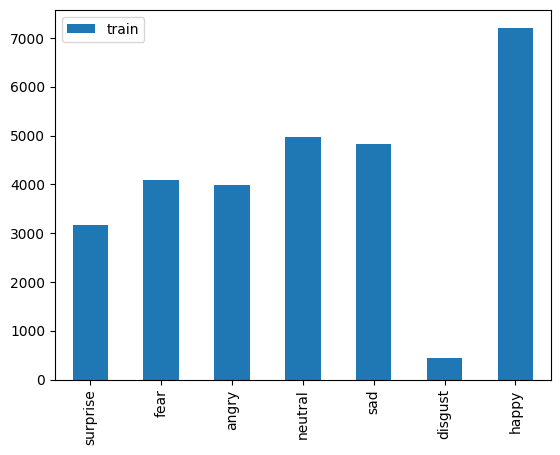

In [4]:
train_count.transpose().plot(kind='bar')

<Axes: >

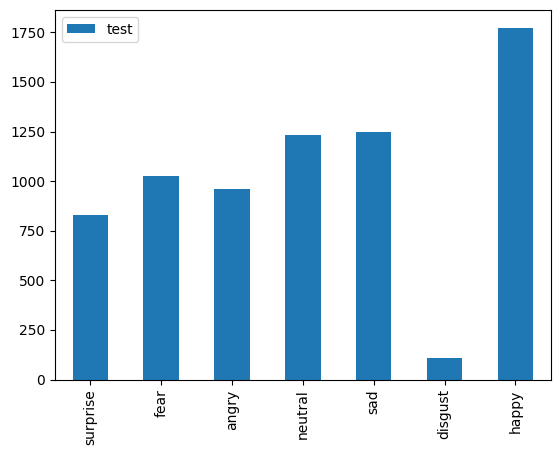

In [5]:
test_count.transpose().plot(kind='bar')

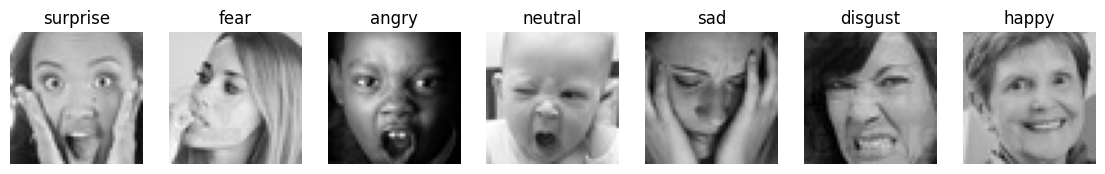

In [6]:
plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_dir):
    img = load_img((train_dir + expression +'/'+ os.listdir(train_dir + expression)[5]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

## Creating train test and validation datasets

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True,
                                   validation_split=0.2)

training_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical',
                                                subset='training')
validation_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical',
                                                subset='validation')

test_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True)
test_set = test_datagen.flow_from_directory(test_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [8]:
# labels
training_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

## Model Architecture

In [9]:
weight_decay = 1e-4

num_classes = 7

model = tf.keras.models.Sequential()

model.add(Conv2D(64, (4,4), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=(48,48,1)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (4,4), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (4,4), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (4,4), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (4,4), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation="linear"))
model.add(Activation('elu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(0.0003), metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,315,335 (5.02 MB)

 Trainable params: 1,314,311 (5.01 MB)

 Non-trainable params: 1,024 (4.00 KB)

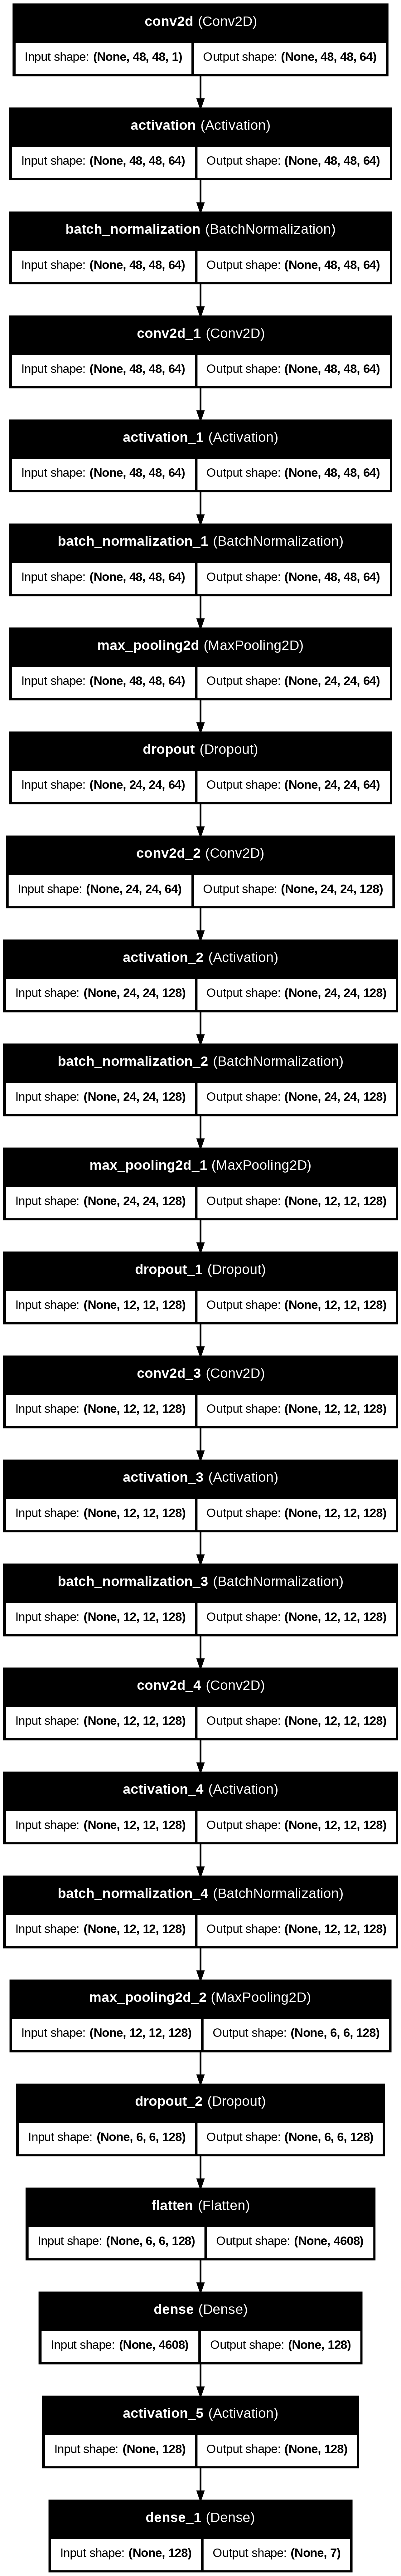

In [10]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [11]:
checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1, restore_best_weights=True,mode="max",patience = 10),
                ModelCheckpoint(
                    filepath='model.weights.best.keras',
                    monitor="val_accuracy",
                    verbose=1,
                    save_best_only=True,
                    mode="max")]

## Model Training

In [12]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = validation_set.n // validation_set.batch_size

history = model.fit(x=training_set,
                 validation_data=validation_set,
                 epochs=200,
                 callbacks=[checkpointer],
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/200
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.2640 - loss: 2.2132
Epoch 1: val_accuracy improved from -inf to 0.27423, saving model to model.weights.best.keras
358/358 ━━━━━━━━━━━━━━━━━━━━ 135s 340ms/step - accuracy: 0.2641 - loss: 2.2123 - val_accuracy: 0.2742 - val_loss: 1.9298
Epoch 2/200
  1/358 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - accuracy: 0.2969 - loss: 1.6190

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.27423 to 0.27563, saving model to model.weights.best.keras
358/358 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.2969 - loss: 1.6190 - val_accuracy: 0.2756 - val_loss: 1.9355
Epoch 3/200
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.3899 - loss: 1.6105
Epoch 3: val_accuracy improved from 0.27563 to 0.43732, saving model to model.weights.best.keras
358/358 ━━━━━━━━━━━━━━━━━━━━ 30s 65ms/step - accuracy: 0.3899 - loss: 1.6104 - val_accuracy: 0.4373 - val_loss: 1.5050
Epoch 4/200
  1/358 ━━━━━━━━━━━━━━━━━━━━ 14s 42ms/step - accuracy: 0.4375 - loss: 1.4641
Epoch 4: val_accuracy did not improve from 0.43732
358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.4375 - loss: 1.4641 - val_accuracy: 0.4366 - val_loss: 1.4935
Epoch 5/200
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.4533 - loss: 1.4571
Epoch 5: val_accuracy improved from 0.43732 to 0.47858, saving model to model.weights.best.keras
358/358 ━━━━━━━━━━━━━━━━━━━━ 36s 65ms

## Model Performance

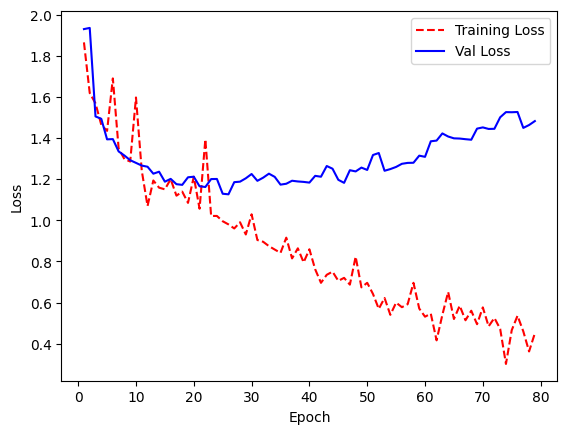

In [13]:
training_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.rcParams['figure.figsize'] = [10, 5]
plt.style.use(['default'])
# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, val_loss, 'b-')
plt.legend(['Training Loss', 'Val Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

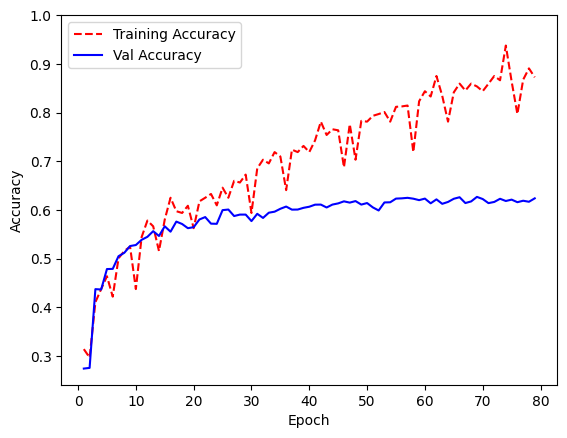

In [14]:
training_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(training_accuracy) + 1)

# Visualize loss history

plt.plot(epoch_count, training_accuracy, 'r--')
plt.plot(epoch_count, val_accuracy, 'b-')
plt.legend(['Training Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(top = 1)
plt.show()

In [15]:
# saving the model
model.save("fer_model.h5")

## Test Accuracy

In [16]:
print(f"Test accuracy = {model.evaluate(test_set ,batch_size=test_set.batch_size,steps=test_set.n // test_set.batch_size)[1]*100}%")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


112/112 ━━━━━━━━━━━━━━━━━━━━ 30s 272ms/step - accuracy: 0.6156 - loss: 1.4396
Test accuracy = 62.37444281578064%


## Confusion Matrix

### Confusion matrix on Training Set

359/359 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step
Confusion Matrix
[[ 493   47  453  785  565  513  340]
 [  53    3   51   82   52   68   40]
 [ 427   52  444  863  563  546  383]
 [ 803   86  802 1434 1064  920  663]
 [ 483   72  541 1034  664  736  442]
 [ 536   58  573 1004  654  660  379]
 [ 349   31  357  669  428  410  293]]
Classification Report
              precision    recall  f1-score   support

       angry       0.16      0.15      0.16      3196
     disgust       0.01      0.01      0.01       349
        fear       0.14      0.14      0.14      3278
       happy       0.24      0.25      0.25      5772
     neutral       0.17      0.17      0.17      3972
         sad       0.17      0.17      0.17      3864
    surprise       0.12      0.12      0.12      2537

    accuracy                           0.17     22968
   macro avg       0.14      0.14      0.14     22968
weighted avg       0.17      0.17      0.17     22968



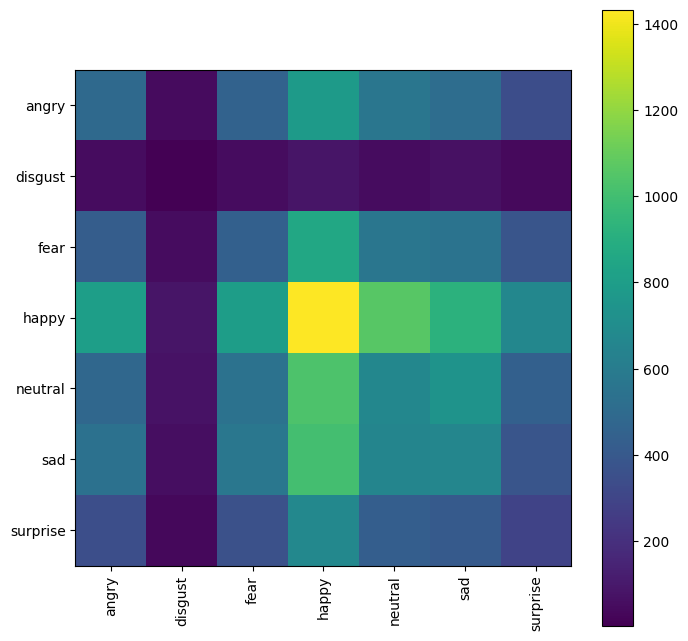

In [17]:
y_pred = model.predict(training_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(training_set.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(training_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

### Confusion Matrix on Validation Dataset

90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step
Confusion Matrix
[[ 87   9 103 222 143 146  89]
 [ 16   0  16  18  21   9   7]
 [109  14  90 231 149 139  87]
 [193  11 174 383 271 260 151]
 [128  11 118 257 192 171 116]
 [122  14 129 234 174 182 111]
 [ 94   7  69 174 110 111  69]]
Classification Report
              precision    recall  f1-score   support

       angry       0.12      0.11      0.11       799
     disgust       0.00      0.00      0.00        87
        fear       0.13      0.11      0.12       819
       happy       0.25      0.27      0.26      1443
     neutral       0.18      0.19      0.19       993
         sad       0.18      0.19      0.18       966
    surprise       0.11      0.11      0.11       634

    accuracy                           0.17      5741
   macro avg       0.14      0.14      0.14      5741
weighted avg       0.17      0.17      0.17      5741



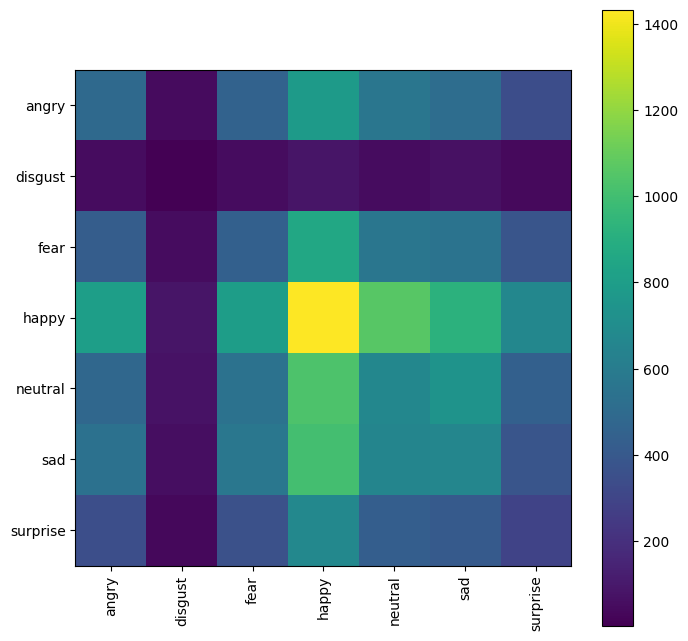

In [18]:
y_pred = model.predict(validation_set)
y_pred = np.argmax(y_pred, axis=1)
cm_val = confusion_matrix(validation_set.classes, y_pred)
print('Confusion Matrix')
print(cm_val)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(validation_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

## Confusion Matrix on Test Dataset

113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step
Confusion Matrix
[[127   6 118 243 179 170 115]
 [ 19   4  16  29  18  17   8]
 [128  12 117 259 200 179 129]
 [237  19 222 447 321 325 203]
 [155  13 179 321 209 230 126]
 [149  17 156 339 242 210 134]
 [104  11 105 202 148 153 108]]
Classification Report
              precision    recall  f1-score   support

       angry       0.14      0.13      0.14       958
     disgust       0.05      0.04      0.04       111
        fear       0.13      0.11      0.12      1024
       happy       0.24      0.25      0.25      1774
     neutral       0.16      0.17      0.16      1233
         sad       0.16      0.17      0.17      1247
    surprise       0.13      0.13      0.13       831

    accuracy                           0.17      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.17      0.17      0.17      7178



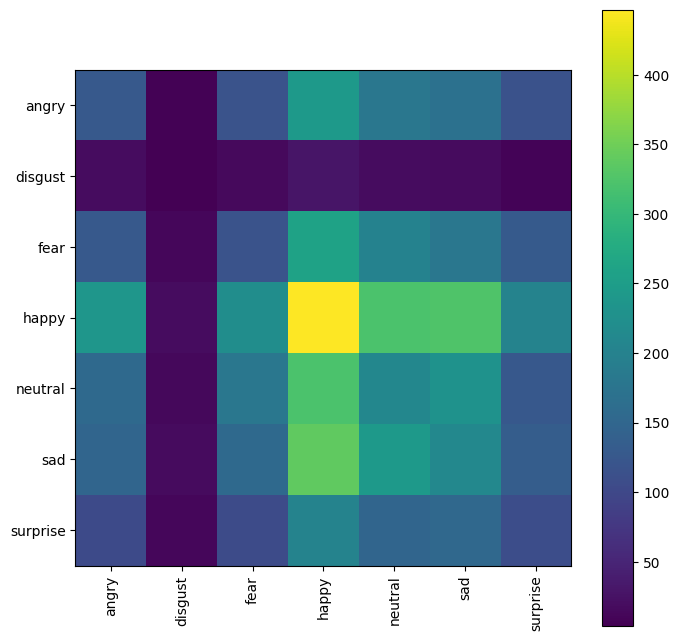

In [19]:
y_pred = model.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)

cm_test = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(test_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_test, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

## Plotting Predictions

In [20]:
# next function assigns one batch to variables, i.e x_test,y_test will have 64 images
x_test,y_test = next(test_set)
predict = model.predict(x_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


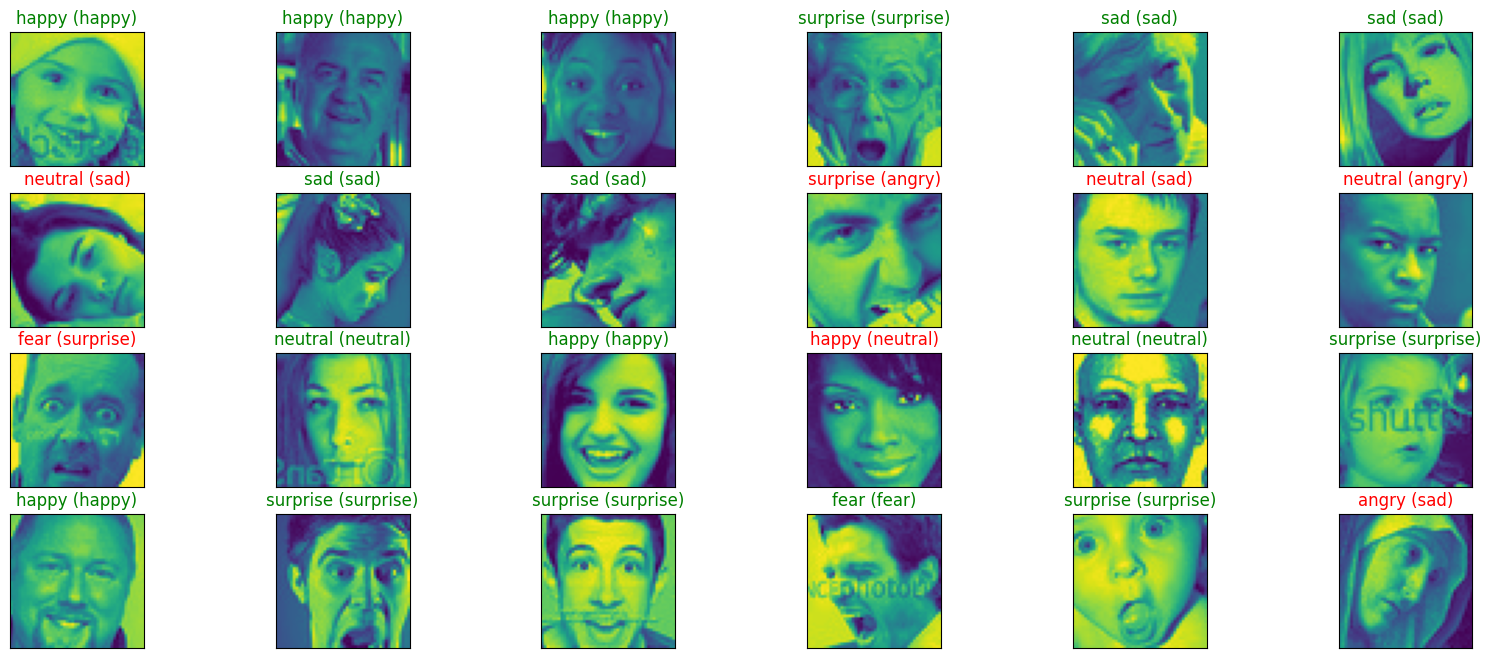

In [21]:
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(x_test.shape[0], size=24, replace=False)):
    ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[index]))
    predict_index = class_labels[(np.argmax(predict[index]))]
    true_index = class_labels[(np.argmax(y_test[index]))]

    ax.set_title("{} ({})".format((predict_index),
                                  (true_index)),
                                  color=("green" if predict_index == true_index else "red"))